In [1]:
import gpflow as gpf
import numpy as np
import simenvs
import tensorflow as tf
import tensorflow_probability as tfp
from experiments.plot.controller import (
    plot_trajectories_over_desired_gating_gp,
    plot_trajectories_over_desired_mixing_prob,
)
from experiments.plot.utils import create_test_inputs
from experiments.utils import sample_env_trajectories
from gpflow import default_float
from gpflow.functions import Constant
from gpflow.inducing_variables import InducingPoints, SharedIndependentInducingVariables
from gpflow.kernels import Matern52, SeparateIndependent
from gpflow.likelihoods import Gaussian
from moderl.controllers import ExplorativeController
from moderl.dynamics import ModeRLDynamics
from moderl.objectives import joint_gating_function_entropy

# bald_objective
# conditional_gating_function_entropy
# independent_gating_function_entropy
from moderl.reward_functions import (
    ControlQuadraticRewardFunction,
    StateDiffRewardFunction,
)
from moderl.rollouts import collect_data_from_env
from mosvgpe.experts import SVGPExpert
from mosvgpe.gating_networks import SVGPGatingNetwork
from mosvgpe.mixture_of_experts import MixtureOfSVGPExperts


tfd = tfp.distributions

/Users/scannea1/python-projects/ModeRL/.direnv/python-3.9.13/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/scannea1/python-projects/ModeRL/.direnv/python-3.9.13/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


In [2]:
random_seed = 42
tf.keras.utils.set_random_seed(random_seed)

In [3]:
env_name = "velocity-controlled-point-mass/scenario-1"
start_state = tf.constant([[2.0, -2.5]], dtype=default_float())
target_state = tf.constant([[1.2, 3.0]], dtype=default_float())

In [4]:
num_experts = 2
num_inducing_experts = 50
num_inducing_gating = 90

In [5]:
env = simenvs.make(env_name)
state_dim = env.observation_spec().shape[0]
action_dim = env.action_spec().shape[0]

No constant_error found in toml config so using default : 0.0


In [6]:
horizon = 15
num_trajectories = 50
width = 1.0

In [7]:
initial_dataset = sample_env_trajectories(
    env=env,
    start_state=start_state,
    horizon=horizon,
    num_trajectories=num_trajectories,
    width=width,
    random_seed=random_seed,
)
X, Y = initial_dataset

In [8]:
def build_SVGPExpert() -> SVGPExpert:
    likelihood = Gaussian(variance=[1.0 for _ in range(state_dim)])
    mean_function = Constant(c=[0.0 for _ in range(state_dim)])
    kernels = [
        Matern52(
            lengthscales=[1.0 for _ in range(state_dim + action_dim)],
            variance=1.0,
        )
        for _ in range(state_dim)
    ]
    kernel = SeparateIndependent(kernels=kernels)
    idx = np.random.choice(range(X.shape[0]), size=num_inducing_experts, replace=False)
    Z = X[idx, ...].reshape(-1, X.shape[1])
    inducing_variable = SharedIndependentInducingVariables(InducingPoints(Z))
    return SVGPExpert(
        kernel=kernel,
        likelihood=likelihood,
        mean_function=mean_function,
        inducing_variable=inducing_variable,
        num_latent_gps=state_dim,
        q_diag=False,
        whiten=True,
    )


experts_list = [build_SVGPExpert() for _ in range(num_experts)]

/Users/scannea1/python-projects/ModeRL/.direnv/python-3.9.13/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


In [9]:
lengthscales = [0.8, 0.8]
kernel_variance = 1.0
active_dims = [0, 1]

In [10]:
idx = np.random.choice(range(X.shape[0]), size=num_inducing_gating, replace=False)
Z = X[idx, ...].reshape(-1, X.shape[1])
kernel = Matern52(
    lengthscales=lengthscales, variance=kernel_variance, active_dims=active_dims
)
inducing_variable = InducingPoints(Z)
gating_network = SVGPGatingNetwork(
    kernel=kernel,
    inducing_variable=inducing_variable,
    mean_function=None,  # Use zero mean function
    q_diag=False,
    whiten=True,
)

In [11]:
mosvgpe = MixtureOfSVGPExperts(experts_list=experts_list, gating_network=gating_network)

In [12]:
# Adam optimiser config
learning_rate = 0.01
epsilon = 1e-8
# Keras fit() args
batch_size = 64
epochs = 20000
verbose = True
validation_split = (
    0.0  # > 0 can lead to no observations from turbulent mode in dataset...
)
# Early stopping callback config
patience = 50
min_delta = 0

In [13]:
dynamics = ModeRLDynamics(
    mosvgpe=mosvgpe,
    state_dim=state_dim,
    desired_mode=0,  # set 0 now and update after training on data
    dataset=initial_dataset,
    learning_rate=learning_rate,
    epsilon=epsilon,
    dynamics_fit_kwargs={
        "batch_size": batch_size,
        "epochs": epochs,
        "verbose": verbose,
        "validation_split": validation_split,
    },
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="loss",
            patience=patience,
            min_delta=min_delta,
            verbose=0,
            restore_best_weights=True,
        )
    ],
)

setting desired mode to 0


## Train dynamics on initial data set

In [14]:
dynamics.optimise()

Epoch 1/20000


2022-10-09 17:41:05.874268: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Mixing probs: (1, 64, 2)
Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Experts probs: (1, 64, 2)
Mixing probs: (1, 64, 2)
Experts probs: (1, 64, 2)
2/2 [==============================] - 8s 19ms/step - loss: 379.5070
Epoch 2/20000
2/2 [==============================] - 0s 4ms/step - loss: 388.7262
Epoch 3/20000
2/2 [==============================] - 0s 12ms/step - loss: 369.8284
Epoch 4/20000
2/2 [==============================] - 0s 5ms/step - loss: 387.3432
Epoch 5/20000
2/2 [==============================] - 0s 5ms/step - loss: 374.9131
Epoch 6/20000
2/2 [==============================] - 0s 12ms/step - loss: 359.3145
Epoch 7/20000
2/2 [==============================] - 0s 12ms/step - loss: 355.2773
Epoch 8/20000
2/2 [==============================] - 0s 4ms/step - loss: 361.6434
Epoch 9/20000
2/2 [==============================] - 0s 13ms/step - loss: 353.2667
Epoch 10/20000
2/2 [==============================] - 0s 4ms/step - loss: 366.0229
Epoch 11/20000
2/2 [==============================] - 0s 12ms/step - loss: 347.4852
Epoch 12/20000
2/2 [=======

2/2 [==============================] - 0s 6ms/step - loss: -230.1645
Epoch 196/20000
2/2 [==============================] - 0s 7ms/step - loss: -180.2414
Epoch 197/20000
2/2 [==============================] - 0s 13ms/step - loss: -267.3001
Epoch 198/20000
2/2 [==============================] - 0s 6ms/step - loss: -236.0150
Epoch 199/20000
2/2 [==============================] - 0s 6ms/step - loss: -205.1462
Epoch 200/20000
2/2 [==============================] - 0s 6ms/step - loss: -265.9928
Epoch 201/20000
2/2 [==============================] - 0s 6ms/step - loss: -238.3469
Epoch 202/20000
2/2 [==============================] - 0s 7ms/step - loss: -161.2952
Epoch 203/20000
2/2 [==============================] - 0s 7ms/step - loss: -248.3611
Epoch 204/20000
2/2 [==============================] - 0s 7ms/step - loss: -208.3055
Epoch 205/20000
2/2 [==============================] - 0s 7ms/step - loss: -227.9369
Epoch 206/20000
2/2 [==============================] - 0s 7ms/step - loss: -202.

2/2 [==============================] - 0s 7ms/step - loss: -331.6997
Epoch 388/20000
2/2 [==============================] - 0s 7ms/step - loss: -372.7882
Epoch 389/20000
2/2 [==============================] - 0s 7ms/step - loss: -346.1824
Epoch 390/20000
2/2 [==============================] - 0s 7ms/step - loss: -326.6613
Epoch 391/20000
2/2 [==============================] - 0s 15ms/step - loss: -393.1720
Epoch 392/20000
2/2 [==============================] - 0s 14ms/step - loss: -395.1208
Epoch 393/20000
2/2 [==============================] - 0s 7ms/step - loss: -373.4505
Epoch 394/20000
2/2 [==============================] - 0s 7ms/step - loss: -331.8223
Epoch 395/20000
2/2 [==============================] - 0s 6ms/step - loss: -245.2740
Epoch 396/20000
2/2 [==============================] - 0s 6ms/step - loss: -364.0930
Epoch 397/20000
2/2 [==============================] - 0s 6ms/step - loss: -364.8323
Epoch 398/20000
2/2 [==============================] - 0s 14ms/step - loss: -39

## Set the desired mode
Set the desired dynamics mode to the one with lowest process noise.

In [15]:
def set_desired_mode(dynamics: ModeRLDynamics) -> int:
    """Sets desired mode to one with lowest process noise
    uses product of output dims
    """
    noise_var_prod = tf.reduce_prod(
        dynamics.mosvgpe.experts_list[0].gp.likelihood.variance
    )
    desired_mode = 0
    for k, expert in enumerate(dynamics.mosvgpe.experts_list):
        if tf.reduce_prod(expert.gp.likelihood.variance) < noise_var_prod:
            noise_var_prod = expert.gp.likelihood.variance
            desired_mode = k
    print("Desired mode is {}".format(desired_mode))
    return desired_mode


dynamics.desired_mode = set_desired_mode(dynamics)

Desired mode is 0
setting desired mode to 0


Make the gating functions kernel hyperparameters and the turbulent dynamics modes noise_variance not trainable.

In [16]:
gpf.utilities.set_trainable(dynamics.mosvgpe.gating_network.gp.kernel, False)
gpf.utilities.set_trainable(
    dynamics.mosvgpe.experts_list[dynamics.desired_mode].gp.likelihood, False
)  # Needed to stop inf in bound due to expert 2 learning very low noise variancek

In [17]:
state_diff_reward_fn = StateDiffRewardFunction(
    weight_matrix=1.0 * tf.eye(state_dim, dtype=default_float()),
    target_state=target_state,
)
control_reward_fn = ControlQuadraticRewardFunction(
    weight_matrix=tf.eye(action_dim, dtype=default_float())
)
reward_fn = state_diff_reward_fn + control_reward_fn

In [18]:
mode_satisfaction_prob = 0.8
exploration_weight = 1.0
explorative_objective_fn = joint_gating_function_entropy
keep_last_solution = True
max_iterations = 150

In [19]:
explorative_controller = ExplorativeController(
    start_state=start_state,
    dynamics=dynamics,
    explorative_objective_fn=explorative_objective_fn,
    reward_fn=reward_fn,
    control_dim=action_dim,
    horizon=horizon,
    max_iterations=max_iterations,
    mode_satisfaction_prob=mode_satisfaction_prob,
    exploration_weight=exploration_weight,
    keep_last_solution=keep_last_solution,
)

Optimisation result:
     fun: 57.95599523212353
     jac: array([-3.43894697e-05,  3.63355241e-04,  1.48993762e-05,  3.90515186e-04,
        1.65770136e-04,  2.67204686e-04,  1.99179651e-04,  2.30477535e-04,
        1.84216630e-04,  2.21251380e-04,  1.60044585e-04,  1.86076830e-04,
        1.42505520e-04,  1.33078263e-04,  1.38910431e-04,  1.08404948e-04,
        1.56441035e-04,  8.74999697e-05,  2.39883746e-04,  4.00504016e-05,
        3.52485365e-04, -1.88829787e-05,  2.56335269e-04,  4.34525166e-04,
        5.50189707e-04, -5.46505230e-05,  5.04334050e-05,  4.58755881e-04,
        9.27987049e-05, -9.58943425e-05])
 message: 'Optimization terminated successfully'
    nfev: 23
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([-0.01985525,  1.92769777, -0.01807272,  1.93430458, -0.01644301,
        1.94083848, -0.01507448,  1.94741312, -0.01393962,  1.95397659,
       -0.01302396,  1.96047998, -0.01232221,  1.96691022, -0.01183151,
        1.97327719, -0.0115491 , 

## Run the MBRL loop

In [20]:
num_episodes = 40
converged = False
test_inputs = create_test_inputs(40000)  # test inputs for plotting

Optimisation result:
     fun: 313.5223973112792
     jac: array([ 2.12028288e+00, -2.97526032e+00,  2.12927074e+00, -2.73196069e+00,
        1.69834081e+00, -2.88398912e+00,  1.89623584e+00, -3.07518430e+00,
        1.39297658e+00, -3.09585882e+00,  1.74275177e+00, -3.02225730e+00,
        1.03754373e+00, -3.35417350e+00,  1.07092688e+00, -4.21059752e+00,
        9.86188131e-01, -4.54059986e+00,  2.92669253e-01, -6.28949127e-01,
        2.74121863e-01, -5.97202361e-01,  7.71966782e-04,  2.84590261e-04,
        5.91873982e-04,  2.63536610e-04,  1.53170231e-04,  3.13304734e-04,
       -2.92133721e-04, -9.59615668e-05])
 message: 'Optimization terminated successfully'
    nfev: 95
     nit: 57
    njev: 57
  status: 0
 success: True
       x: array([-0.33502574,  4.77710284,  1.38415021,  4.74130109, -1.13662155,
        4.90579243,  1.84556394,  4.56050344, -1.22290816,  4.80885334,
        1.0148871 ,  4.76464605, -1.50160146,  4.69336254, -2.69709463,
        1.23299568, -2.50085849, 

3/3 [==============================] - 0s 7ms/step - loss: -480.4473
Epoch 180/20000
3/3 [==============================] - 0s 9ms/step - loss: -471.0356
Epoch 181/20000
3/3 [==============================] - 0s 7ms/step - loss: -473.6453
Epoch 182/20000
3/3 [==============================] - 0s 8ms/step - loss: -485.1450
Epoch 183/20000
3/3 [==============================] - 0s 9ms/step - loss: -456.0358
Epoch 184/20000
3/3 [==============================] - 0s 7ms/step - loss: -472.0307
Epoch 185/20000
3/3 [==============================] - 0s 7ms/step - loss: -435.7243
Epoch 186/20000
3/3 [==============================] - 0s 7ms/step - loss: -403.4883
Epoch 187/20000
3/3 [==============================] - 0s 7ms/step - loss: -458.7783
Epoch 188/20000
3/3 [==============================] - 0s 7ms/step - loss: -446.4910
Epoch 189/20000
3/3 [==============================] - 0s 7ms/step - loss: -476.6434
Epoch 190/20000
3/3 [==============================] - 0s 7ms/step - loss: -412.6

3/3 [==============================] - 0s 8ms/step - loss: -416.7253
Epoch 48/20000
3/3 [==============================] - 0s 8ms/step - loss: -427.7448
Epoch 49/20000
3/3 [==============================] - 0s 7ms/step - loss: -429.6691
Epoch 50/20000
3/3 [==============================] - 0s 8ms/step - loss: -411.0905
Epoch 51/20000
3/3 [==============================] - 0s 7ms/step - loss: -464.0231
Epoch 52/20000
3/3 [==============================] - 0s 7ms/step - loss: -444.5204
Epoch 53/20000
3/3 [==============================] - 0s 7ms/step - loss: -370.3383
Epoch 54/20000
3/3 [==============================] - 0s 8ms/step - loss: -457.4066
Epoch 55/20000
3/3 [==============================] - 0s 7ms/step - loss: -412.9942
Epoch 56/20000
3/3 [==============================] - 0s 8ms/step - loss: -439.6989
Epoch 57/20000
3/3 [==============================] - 0s 8ms/step - loss: -449.1746
Epoch 58/20000
3/3 [==============================] - 0s 8ms/step - loss: -437.4238
Epoch 5

Epoch 1/20000
3/3 [==============================] - 0s 24ms/step - loss: -458.8848
Epoch 2/20000
3/3 [==============================] - 0s 8ms/step - loss: -419.3208
Epoch 3/20000
3/3 [==============================] - 0s 10ms/step - loss: -444.5549
Epoch 4/20000
3/3 [==============================] - 0s 12ms/step - loss: -474.6850
Epoch 5/20000
3/3 [==============================] - 0s 7ms/step - loss: -447.5597
Epoch 6/20000
3/3 [==============================] - 0s 8ms/step - loss: -439.5275
Epoch 7/20000
3/3 [==============================] - 0s 7ms/step - loss: -427.4901
Epoch 8/20000
3/3 [==============================] - 0s 7ms/step - loss: -466.9459
Epoch 9/20000
3/3 [==============================] - 0s 8ms/step - loss: -466.1712
Epoch 10/20000
3/3 [==============================] - 0s 8ms/step - loss: -451.5863
Epoch 11/20000
3/3 [==============================] - 0s 8ms/step - loss: -452.5802
Epoch 12/20000
3/3 [==============================] - 0s 8ms/step - loss: -473.569

3/3 [==============================] - 0s 8ms/step - loss: -449.7511
Epoch 64/20000
3/3 [==============================] - 0s 8ms/step - loss: -442.1984
Epoch 65/20000
3/3 [==============================] - 0s 11ms/step - loss: -478.1031
Epoch 66/20000
3/3 [==============================] - 0s 7ms/step - loss: -455.0374
Epoch 67/20000
3/3 [==============================] - 0s 8ms/step - loss: -455.2127
Epoch 68/20000
3/3 [==============================] - 0s 8ms/step - loss: -397.8573
Epoch 69/20000
3/3 [==============================] - 0s 7ms/step - loss: -458.6752
Epoch 70/20000
3/3 [==============================] - 0s 7ms/step - loss: -464.6434
Epoch 71/20000
3/3 [==============================] - 0s 7ms/step - loss: -460.7226
Epoch 72/20000
3/3 [==============================] - 0s 7ms/step - loss: -423.2298
Epoch 73/20000
3/3 [==============================] - 0s 7ms/step - loss: -450.2462
Epoch 74/20000
3/3 [==============================] - 0s 7ms/step - loss: -457.0980
Epoch 


KeyboardInterrupt



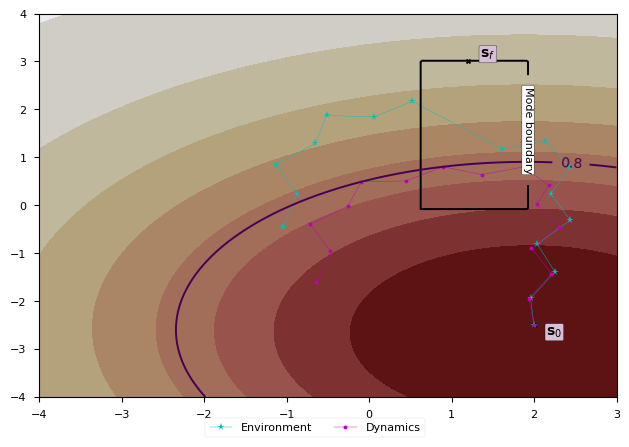

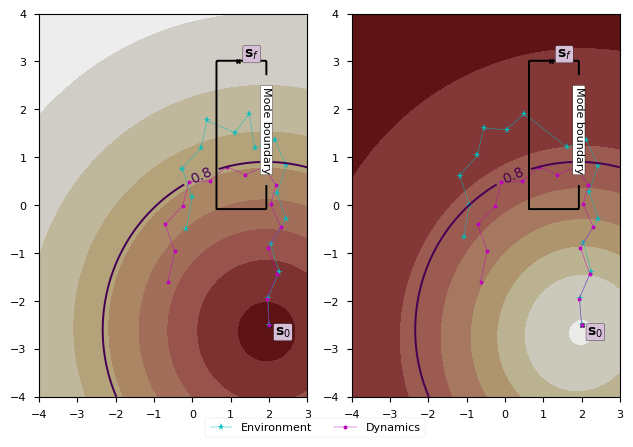

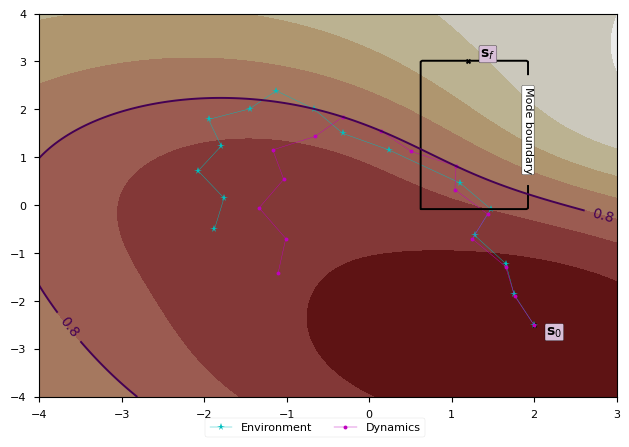

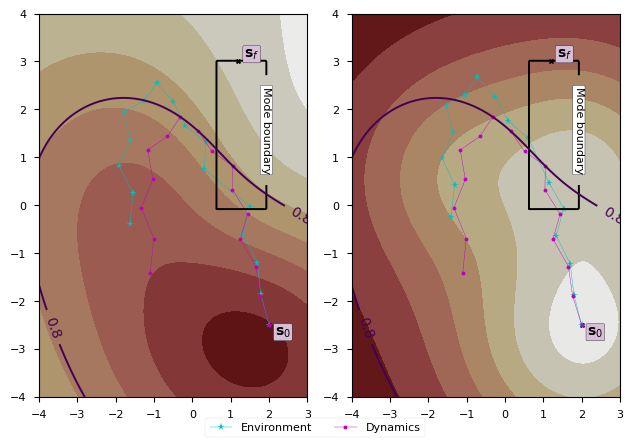

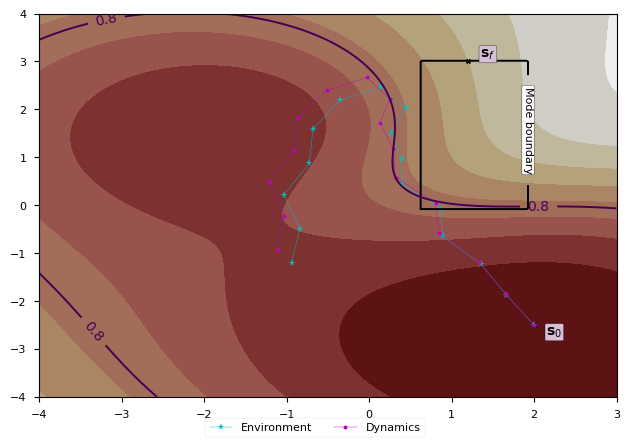

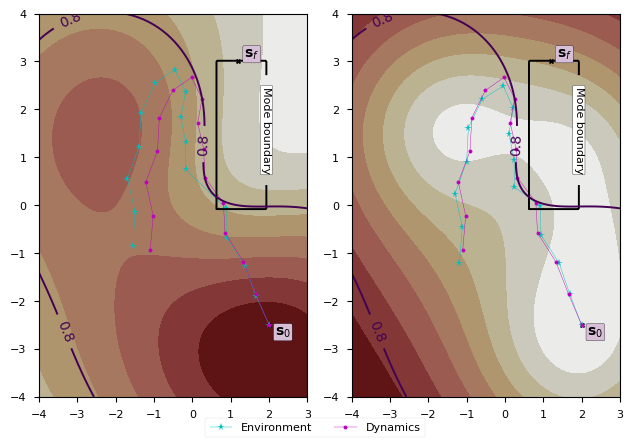

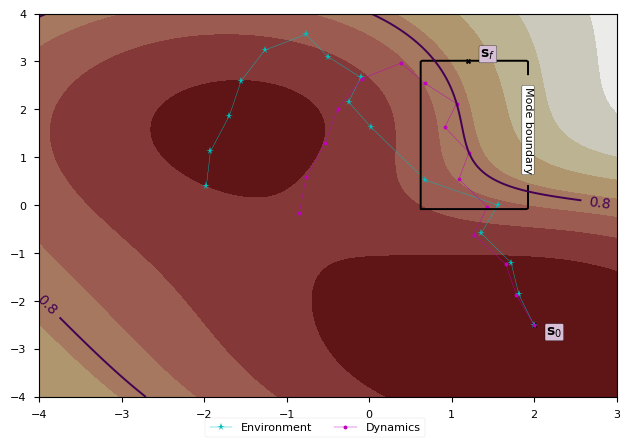

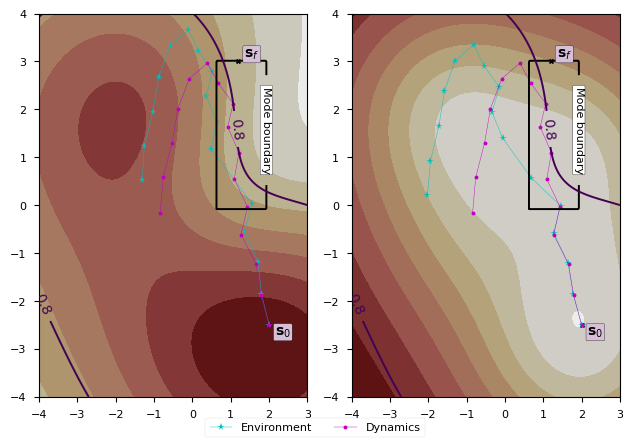

In [21]:
for episode in range(0, num_episodes):
    # Train dynamics model
    if episode > 0:
        dynamics.optimise()

    # Optimise controller using constrained objective
    _ = explorative_controller.optimise()

    # Rollout the controller in env to collect state transition data
    X, Y = collect_data_from_env(
        env=env,
        start_state=start_state,
        controls=explorative_controller(),
    )
    dynamics.update_dataset(dataset=(X, Y))

    # Visualising each episode by plotting controller over gating network posterior
    fig = plot_trajectories_over_desired_mixing_prob(
        env,
        controller=explorative_controller,
        test_inputs=test_inputs,
        target_state=target_state,
    )

    fig = plot_trajectories_over_desired_gating_gp(
        env,
        controller=explorative_controller,
        test_inputs=test_inputs,
        target_state=target_state,
    )